In [1]:
import pdb,sys,os
import anndata
import scanpy as sc
sc.settings.verbosity = 0
import argparse
import copy
import numpy as np
import scipy

import timeit
import warnings
warnings.filterwarnings('ignore')

from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
from typing import Tuple


/mnt/data/jingtao2/anaconda3/envs/semi/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import scSemiProfiler as semi

In [3]:
from scSemiProfiler.utils import *

# Example
We provide an example dataset containing 12 samples from COVID-19 patients with 6 different severity levels. We will go through the process of using scSemiProfiler to semi-profile this example cohort. Then we will evaluate the semi-profiling performance by comparing the downstream anlaysis results using the semi-profiled cohort and the real-profiled cohort. We will show that even with only 2 representatives, we can accurately reproduce single-cell level downstream analysis results. Particularly, samples of different COVID-19 severity level can also be accurately inferred.

## Step 1 Initial Setup 
The user provided bulk data is preprocessed, dimensionality reduced, and clustered. 
The sample closest to the cluster centroids are selected as initial representatives.\
*Estimated Time: Less than 1 minute*

In [4]:
name = 'devexample'
bulk = 'example_data/bulkdata.h5ad'
normed = 'yes'
geneselection = 'no'
batch = 2

In [6]:
semi.initsetup(name, bulk,normed,geneselection,batch)

'''
scSemiProfiler.initsetup.initsetup(name, bulk, normed = 'no', 
geneselection = 'yes', batch = 4)

Parameters:
- name ('str'): Project name. 
- bulk ('str'): Path to bulk data. 
- normed ('str'): Whether the data has been library size normed or not. 
- geneselection: ('str'): Whether to perform gene selection.
- batch ('str'): Representative selection batch size.

Returns:
- None
'''

Start initial setup
Initial setup finished. Among 12 total samples, selected 2 representatives:
BGCV09_CV0279
MH9143426


"\nscSemiProfiler.initsetup.initsetup(name, bulk, normed = 'no', \ngeneselection = 'yes', batch = 4)\n\nParameters:\n- name ('str'): Project name. \n- bulk ('str'): Path to bulk data. \n- normed ('str'): Whether the data has been library size normed or not. \n- geneselection: ('str'): Whether to perform gene selection.\n- batch ('str'): Representative selection batch size.\n\nReturns:\n- None\n"

In [7]:
_ = estimate_cost(12,2)

'''
estimate_cost():

Parameters:
- total_samples ('int'): The total number of samples in the cohort.
- n_representatives ('int'): The number of representative samples.

Returns:
- semicost ('float'): Estimated cost for semi-profiling.
- realcost ('float'): Estimated cost for conducting single-cell profiling for the entire cohort.
'''


Estimated semi-profiling cost: $11320.0
Estimated cost if conducting real single-cell profiling: $18000.0
Percentage saved: 37.1%


"\nestimate_cost():\n\nParameters:\n- total_samples ('int'): The total number of samples in the cohort.\n- n_representatives ('int'): The number of representative samples.\n\nReturns:\n- semicost ('float'): Estimated cost for semi-profiling.\n- realcost ('float'): Estimated cost for conducting single-cell profiling for the entire cohort.\n"

## Step 1.5 Acquiring Single-cell Data for Representatives
The user will sequence the representatives to obtain their actual single-cell data. In our example, we offer a function that allows for the extraction of representatives' single-cell data from a pre-prepared dataset.\
*Estimated Time: Less than 1 minute*

In [8]:
semi.get_eg_representatives(name)

'''
get_eg_representatives(name):

Parameters:
- name ('str'): Project name. 

Returns:
None
'''

Obtained single-cell data for representatives.


"\nget_eg_representatives(name):\n\nParameters:\n- name ('str'): Project name. \n\nReturns:\nNone\n"

## Step 2 Single-cell Processing & Feature Augmentation
In this step, we preprocess the representatives' single-cell data and apply various feature augmentations.These enhancements include the addition of gene set scores, aggregation of neighbor cell information, and calculation of gene importance weights.\
*Estimated Time: 2 minutes for each sample with 7000 cells*

In [9]:
semi.scprocess(name=name,singlecell=name+'/representative_sc.h5ad',normed='yes',cellfilter='no',threshold=1e-3,geneset='yes',weight='yes',k=15)


Processing representative single-cell data
Removing background noise
Computing geneset scores
GMT file c2.cp.v7.4.symbols.gmt loading ... 
2922
Number of genes in c2.cp.v7.4.symbols.gmt 4240
GMT file c2.cp.v7.4.symbols.gmt loading ... 
2922
Number of genes in c2.cp.v7.4.symbols.gmt 4240
Augmenting and saving single-cell data.
Finished processing representative single-cell data


"\nscSemiProfiler.scprocess.scprocess(name,singlecell,normed = 'no',\ncellfilter = 'yes',threshold = 1e-3,geneset = 'human',weight = 0.5, \nk = 15)\n\nParameters:\n- name ('str'): Project name.\n- singlecell ('str'): Path to representatives' single-cell data.\n- normed ('str'): Whether the data has been library size normed or not.\n- cellfilter: ('str'): Whether to perform cell selection.\n- threshold ('float'): Threshold for background noise removal.\n- geneset ('str'): Gene set file name. \n- weight ('float'): The proportion of top features to increase importance weight.\n- k ('int'): K for the K-NN graph built for cells.\n\nReturns:\n- None\n"

## Step 3 Single-cell Inference
In this step, we employ a VAE-GAN-based deep generative model to infer the single-cell data for each target (non-representative) sample.\
The model training is divided into three distinct stages:

1. **Pretrain 1**: The model is trained to reconstruct the representatives' single-cell data.

2. **Pretrain 2**: The model continues its reconstruction training in full batch mode, now incorporating an additional "representative bulk loss" term in the loss function. This term ensures that the reconstructed cells' average expression is similar to pseudobulk.

3. **Inference**: The bulk data difference between the representative and target sample is integrated into the generator's reconstruction process through a 'target bulk loss'. This guides the generator to accurately infer the target sample's cells.


*Estimated Time for Samples with Approximately 7000 Cells*:
   - Pretrain 1: 15 minutes per sample
   - Pretrain 2: 5 minutes per sample
   - Inference: 30 minutes per sample

In [ ]:
representatives = name + '/status/init_representatives.txt'
cluster = name + '/status/init_cluster_labels.txt'

bulktype = 'pseudobulk'
semi.scinfer(name, representatives,cluster,None,bulktype)



## Performance evaluation

After the inference is finished for the cohort, we first perform some basic visualization to see if the model training was successful.

In [6]:
repres = []
f=open(name + '/status/init_representatives.txt','r')
lines = f.readlines()
f.close()
for l in lines:
    repres.append(int(l.strip()))

cl = []
f=open(name + '/status/init_cluster_labels.txt','r')
lines = f.readlines()
f.close()
for l in lines:
    cl.append(int(l.strip()))

### Reconstruction
Firstly, successful pretrain should generate near perfect reconstruction. We compare the representative's reconstructed cells with the original ones.


    Visualize the performance of reconstruction by plotting the original and reconstructed data in the same UMAP.

    Parameters
    ----------
    name
        Project name
    representative:
        Representative sample ID (string or int)

    Returns
    -------
        None

    Example
    -------
    >>> name = 'project name'
    >>> visualize_recon(name, 6)

    
INFO     Generating sequential column names                                                                        


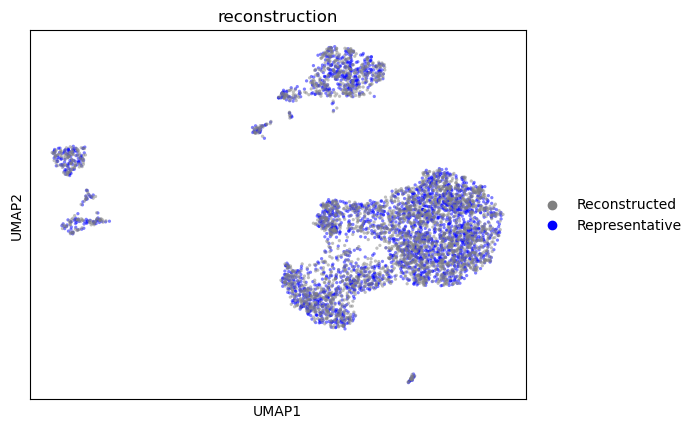

In [11]:
print(visualize_recon.__doc__)
visualize_recon(name, 6)

The overlap indicates the reconstructed cells and representative cells are similar.

### Target sample inference
Then, for any target sample, successful inference should generate target cells closer to the target ground truth than to the representative cells.


    Visualize the inference performance by plotting the representative, inferred target, and target ground truth in the same UMAP.

    Parameters
    ----------
    name
        Project name
    target:
        Target sanmple ID (number)
    representatives:
        Representatives sample IDs (int)
    cluster_labels:
        Cluster labels
        
    Returns
    -------
        None
        
    Example
    -------
    >>> name = 'project name'
    >>> 
    >>> # load representatives and cluster labels lists
    >>> repres = []
    >>> f=open(name + '/status/init_representatives.txt','r')
    >>> lines = f.readlines()
    >>> f.close()
    >>> for l in lines:
    >>>     repres.append(int(l.strip()))
    >>> 
    >>> cl = []
    >>> f=open(name + '/status/init_cluster_labels.txt','r')
    >>> lines = f.readlines()
    >>> f.close()
    >>> for l in lines:
    >>>     cl.append(int(l.strip()))
    >>>
    >>> visualize_inferred(name, 0, repres, cl)
    


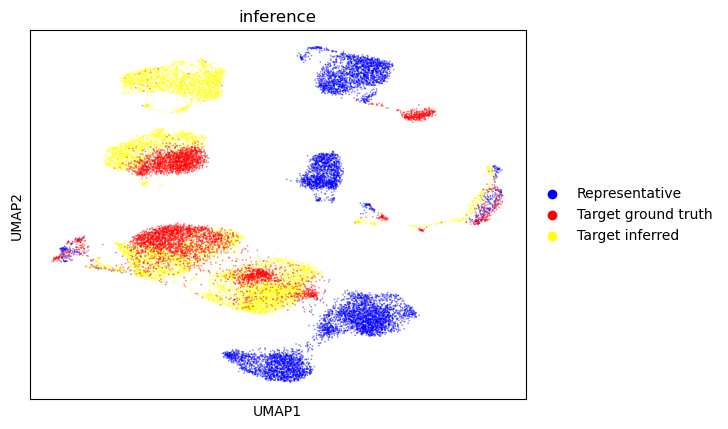

In [12]:
print(visualize_inferred.__doc__)
visualize_inferred(name, 0, repres, cl)

The overlap between the target inferred cells and target ground truth indicates good inference performance.

### Check training loss curve
visualizing the loss curve during training:


    Visualize the training loss curves

    Parameters
    ----------
    name
        Project name
    reprepid:
        Representative sanmple ID 
    tgtpid:
        target sample IDs 
    stage:
        The training stage to visualize, 1: pretrain1; 2: pretrain2; 3: inference 
        
    Returns
    -------
        None
        
    Example
    -------
    >>> name = 'project name'
    >>> loss_curve(name, reprepid='BGCV09_CV0279',tgtpid=None,stage=1) # or loss_curve(name, sids, reprepid=6,tgtpid=None,stage=1)

        
    


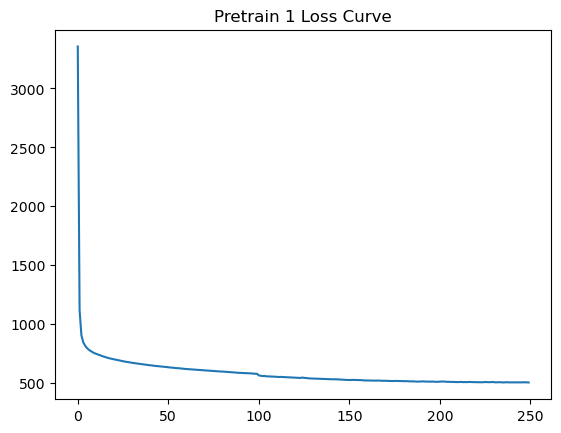

In [13]:
# PRETRAIN 1
# select a representative and check pretrain 1 loss curve
print(loss_curve.__doc__)
loss_curve(name, reprepid='BGCV09_CV0279',tgtpid=None,stage=1) # or loss_curve(name, sids, reprepid=6,tgtpid=None,stage=1)

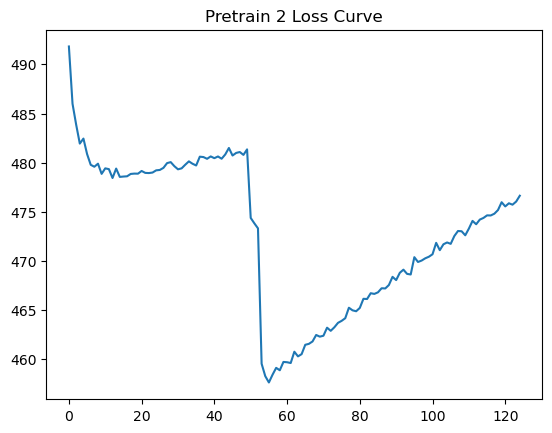

In [14]:
# PRETRAIN 2
loss_curve(name, reprepid='BGCV09_CV0279',tgtpid=None,stage=2) 

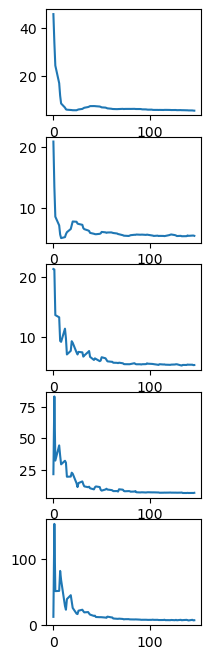

In [15]:
# INFERENCE
# target bulk loss during 5 ministages for inference
loss_curve(name, reprepid=6,tgtpid=1,stage=3)

## Comprehensive evaluation using more downstream tasks
We can assemble the representatives' single-cell data and all inferred single-cell data into a semi-profiled cohort and use it to do all kinds of single-cell analysis. We compare the analysis results generated using the real-profiled cohort and semi-profiled cohort to evaluate the performance of semi-profiling.

### Assemble semi-profiled cohort
(training an MLP to annotate the cell types takes around 5 minutes)

In [16]:
representatives = repres
cluster_labels = cl
print(assemble_cohort.__doc__)
semisdata = assemble_cohort(name,
                representatives,
                cluster_labels,
                celltype_key = 'celltypes',
                sample_info_keys = ['states_collection_sum'])



    Assemble inferred sample data and representative sample data into semi-profiled cohort and annotate the celltype. 
    
    Parameters
    ----------
    name: 
        Project name
    representatives:
        Either a list of representatives or path to a txt file specifying the representative information
    cluster_labels:
        Either a list of sample cluster labels or path to a txt file specifying the sample cluster label information
    celltype_key:
        The key in .obs specifying the cell type information
    sample_info_keys:
        Keys for other sample-level information to be stored in the assembled dataset

    Returns
    -------
    semidata:
        The assembled and annotated semi-profiled dataset

    Example
    -------
    >>> semisdata = assemble_cohort(name,
    >>>                 repre,
    >>>                 cls,
    >>>                 celltype_key = 'celltypes',
    >>>                 sample_info_keys = ['states_collection_sum'])


    
Start asse

### Read the real-profiled single-cell data to compare to

In [17]:
gtdata = anndata.read_h5ad('example_data/scdata.h5ad')

### Compare the UMAP visualization
(The dimensionality reduction and neighbor graph calculation could be slow, taking around 5 minutes)


    Compare the real-profiled and semi-profiled datasets by plotting them in a same UMAP
    
    Parameters
    ----------
    semidata:
        Semi-profiled dataset
    name: 
        Project name
    representatives:
        Path to the txt file storing the representative information
    cluster_labels:
        Path to the txt file storing the cluster label information
    celltype_key:
        The key in .obs specifying the cell type information

    Returns
    -------
    combdata
        Combined dataset, with real-profiled cells in the front
    gtdata
        Real-profiled dataset
    semidata
        Semi-profiled dataset
        
    Example
    -------
    >>> combined_data,gtdata,semidata = compare_umaps(
    >>>             semidata = semisdata, # assembled semi-profiled dataset
    >>>             name = name,
    >>>             representatives = name + '/status/init_representatives.txt',
    >>>             cluster_labels = name + '/status/init_cluster_labels.txt',
 

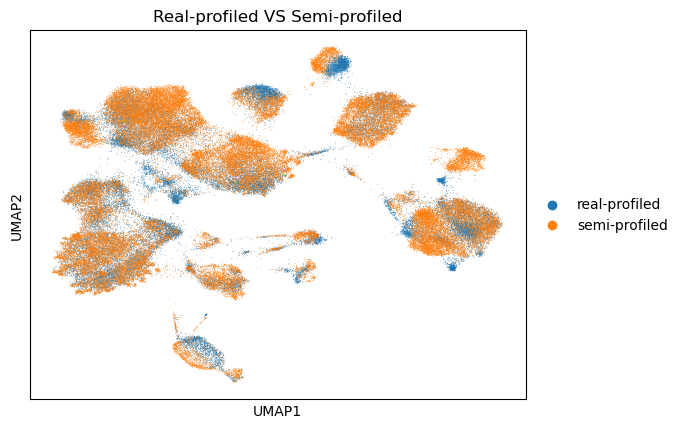

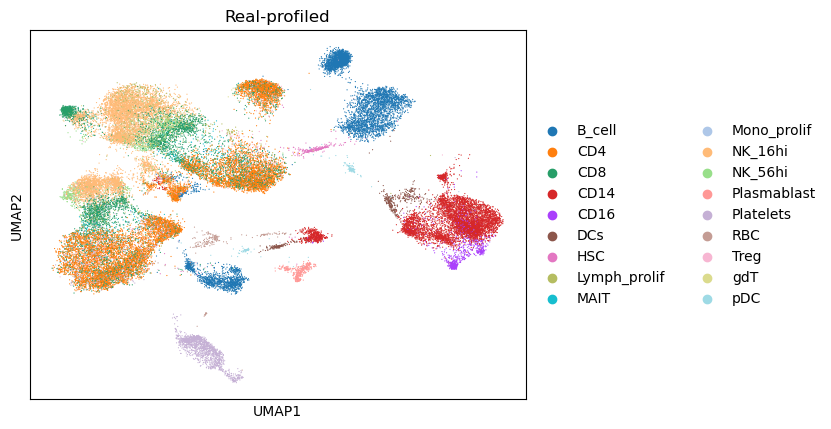

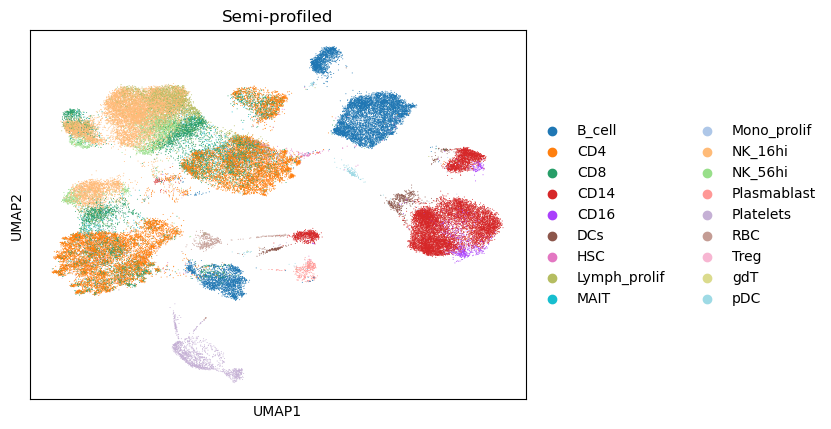

In [19]:
st= timeit.default_timer()
print(compare_umaps.__doc__)
combined_data,gtdata,semidata = compare_umaps(
            semidata = semisdata,
            name = name,
            representatives = name + '/status/init_representatives.txt',
            cluster_labels = name + '/status/init_cluster_labels.txt',
            celltype_key = 'celltypes'
            )



### Compare cell type composition

In [20]:

totaltypes = np.array(semisdata.obs['celltypes'].cat.categories)

print(celltype_proportion.__doc__)


gtprop = celltype_proportion(gtdata,totaltypes)
semiprop = celltype_proportion(semisdata,totaltypes)



print('Pearson Correlation between the two versions of cell type proportions:')
print(scipy.stats.pearsonr(gtprop,semiprop))


    Compute the cell type proportion in a dataset
    
    Parameters
    ----------
    adata:
        The dataset to investigate
    totaltypes:
        The total cell types to consider

    Returns
    -------
    prop
        Cell type proportion
        
    Example
    -------
    >>> real_prop = celltype_proportion(real_rep,totaltypes)
    
Pearson Correlation between the two versions of cell type proportions:
PearsonRResult(statistic=0.9796049855541679, pvalue=1.412076231313769e-12)



    Visualizing the cell type composition in each group.
    
    Parameters
    ----------
    adata:
        The dataset to investigate
    colormap:
        The colormap for visualization
    groupby:
        The key in .obs specifying groups.
    save:
        Whether to save the plot or not
    title:
        Plot title

    Returns
    -------
        None

    Example
    -------
    >>> groupby = 'states_collection_sum'
    >>> composition_by_group(
    >>>     adata = gtdata,
    >>>     groupby = groupby,
    >>>     title = 'Ground truth'
    >>>     )

        
    


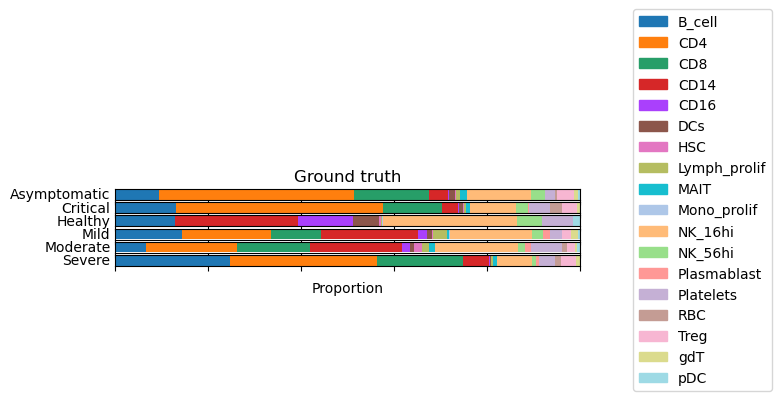

In [22]:
groupby = 'states_collection_sum'
print(composition_by_group.__doc__)
composition_by_group(
    adata = gtdata,
    groupby = groupby,
    title = 'Ground truth'
    )


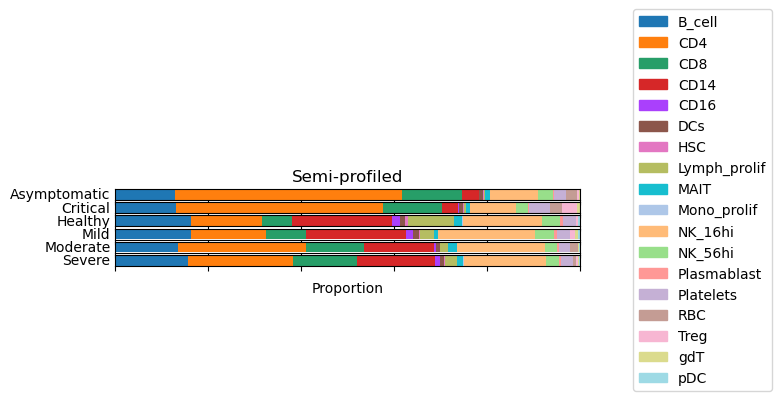

In [23]:
groupby = 'states_collection_sum'
composition_by_group(
    adata = semisdata,
    groupby = groupby,
    title = 'Semi-profiled'
    )

### Compare gene set activation pattern
We use the interferon pathway used in the COVID-19 study as an example.

In [24]:
# adapted from the COVID-19 study's GitHub repository https://www.nature.com/articles/s41591-021-01329-2
# https://www.gsea-msigdb.org/gsea/msigdb/cards/GO_RESPONSE_TO_TYPE_I_INTERFERON
IFN_genes = ["ABCE1", "ADAR", "BST2", "CACTIN", "CDC37", "CNOT7", "DCST1", "EGR1", "FADD", "GBP2", 	"HLA-A", 	"HLA-B", 	"HLA-C", 	"HLA-E", 	"HLA-F", 	"HLA-G", 	"HLA-H", 	"HSP90AB1", 	"IFI27", 	"IFI35", 	"IFI6", 	"IFIT1", 	"IFIT2", 	"IFIT3", 	"IFITM1", 	"IFITM2", 	"IFITM3", 	"IFNA1", 	"IFNA10", 	"IFNA13", 	"IFNA14", 	"IFNA16", 	"IFNA17", 	"IFNA2", 	"IFNA21", 	"IFNA4", 	"IFNA5", 	"IFNA6", 	"IFNA7", 	"IFNA8", 	"IFNAR1", 	"IFNAR2", 	"IFNB1", 	"IKBKE", 	"IP6K2", 	"IRAK1", 	"IRF1", 	"IRF2", 	"IRF3", 	"IRF4", 	"IRF5", 	"IRF6", 	"IRF7", 	"IRF8", 	"IRF9", 	"ISG15", 	"ISG20", 	"JAK1", 	"LSM14A", 	"MAVS", 	"METTL3", 	"MIR21", 	"MMP12", 	"MUL1", 	"MX1", 	"MX2", 	"MYD88", 	"NLRC5", 	"OAS1", 	"OAS2", 	"OAS3", 	"OASL", 	"PSMB8", 	"PTPN1", 	"PTPN11", 	"PTPN2", 	"PTPN6", 	"RNASEL", 	"RSAD2", 	"SAMHD1", 	"SETD2", 	"SHFL", 	"SHMT2", 	"SP100", 	"STAT1", 	"STAT2", 	"TBK1", 	"TREX1", 	"TRIM56", 	"TRIM6", 	"TTLL12", 	"TYK2", 	"UBE2K", 	"USP18", 	"WNT5A", "XAF1", "YTHDF2", "YTHDF3", "ZBP1"]


    Generate heatmaps for visualizing gene set activation pattern in a dataset.
    
    Parameters
    ----------
    adata:
        The dataset to investigate
    genes:
        The list of genes in the gene set
    condition_key:
        The key in .obs specifying different sample conditions.
    celltype_key:
        The key in .obs specifying cell type information
    baseline:
        Baseline condition

    Returns
    -------
    pattern
        np.array
        
    Example
    -------
    >>> gtmtx = geneset_pattern(gtdata,IFN_genes,'states_collection_sum','celltypes')
    


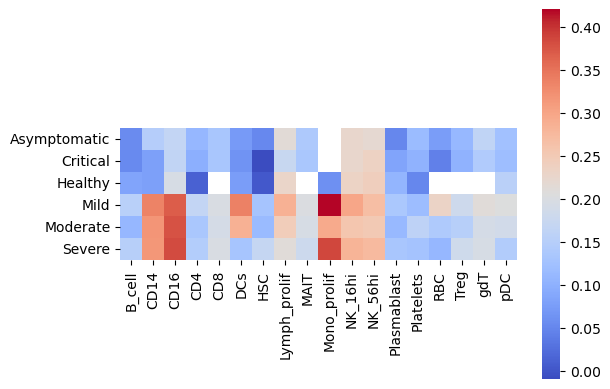

In [25]:
print(geneset_pattern.__doc__)
gtmtx = geneset_pattern(gtdata,IFN_genes,'states_collection_sum','celltypes')


In [26]:
# check if the data is logged
if semisdata.X.max() > 20:
    sc.pp.log1p(semisdata)

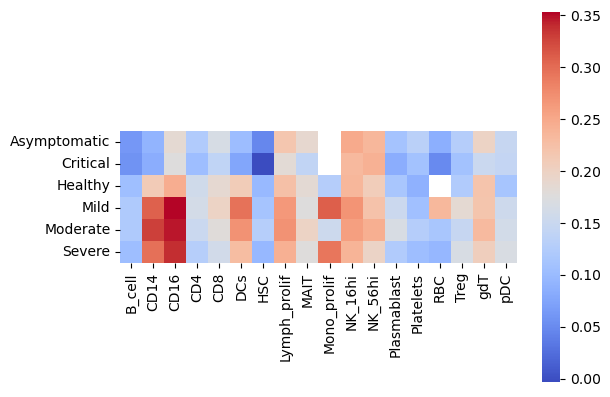

In [27]:
semismtx = geneset_pattern(semisdata,IFN_genes,'states_collection_sum','celltypes')

In [28]:
print('Correlation between the two heatmaps:')
scipy.stats.pearsonr(np.nan_to_num(gtmtx.flatten(),0),np.nan_to_num(semismtx.flatten(),0))

Correlation between the two heatmaps:


PearsonRResult(statistic=0.8308405556770692, pvalue=9.708184603823858e-29)

Based on only 2 representatives, the semi-profiled data reproduces the pattern for all COVID-19 severity levels accurately.

### Compare top cell type signature genes


    Use dotplot to compare the cell type signatures found using the real-profiled dataset and the semi-profiled datset.
    
    Parameters
    ----------
    gtdata:
        The real-profiled dataset
    semisdata:
        The semi-profiled dataset
    celltype_key:
        The key in .obs specifying the cell type labels

    Returns
    -------
        None

    Example
    -------
    >>> celltype_signature_comparison(gtdata=gtdata,semisdata=semisdata,celltype_key='celltypes')
    


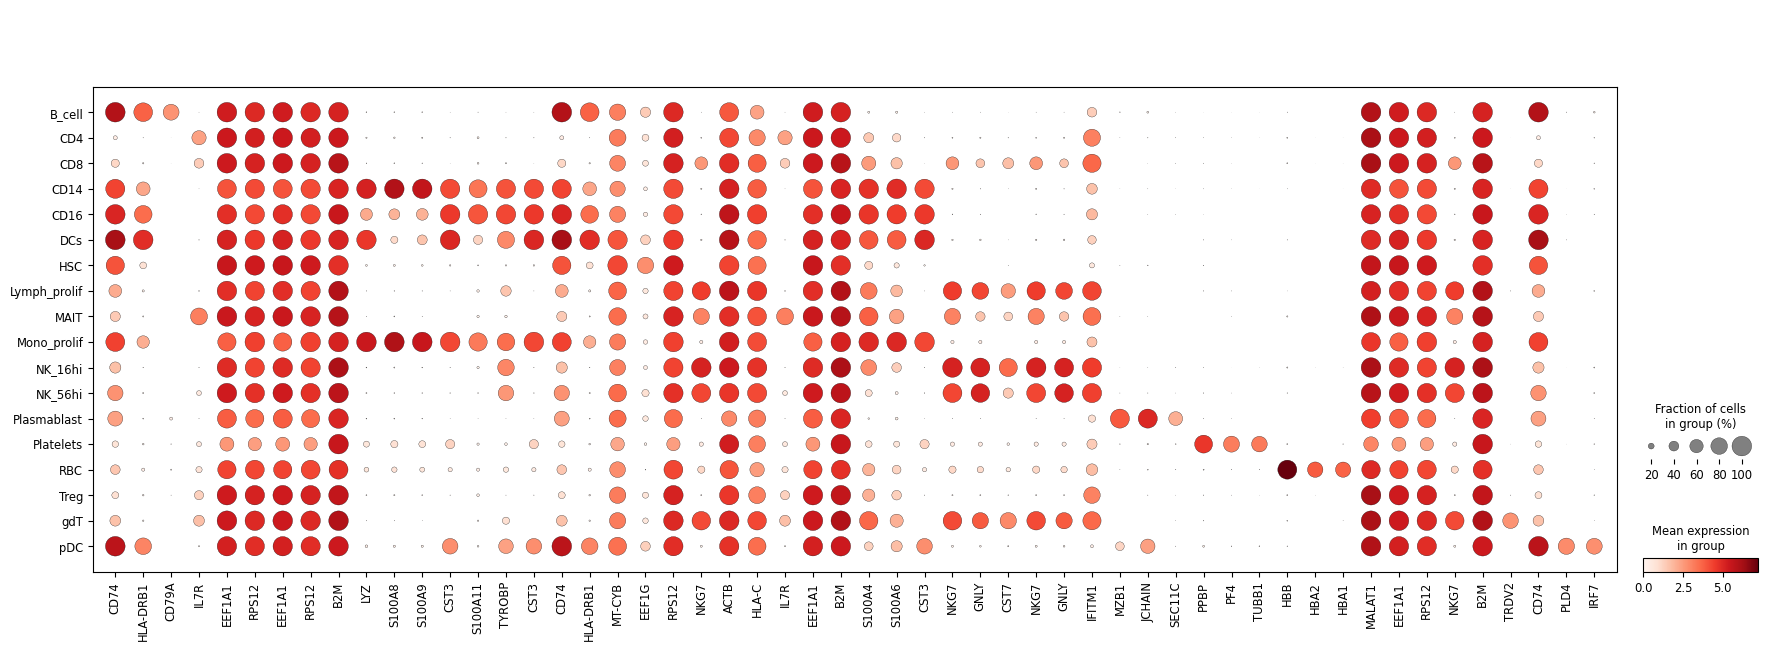

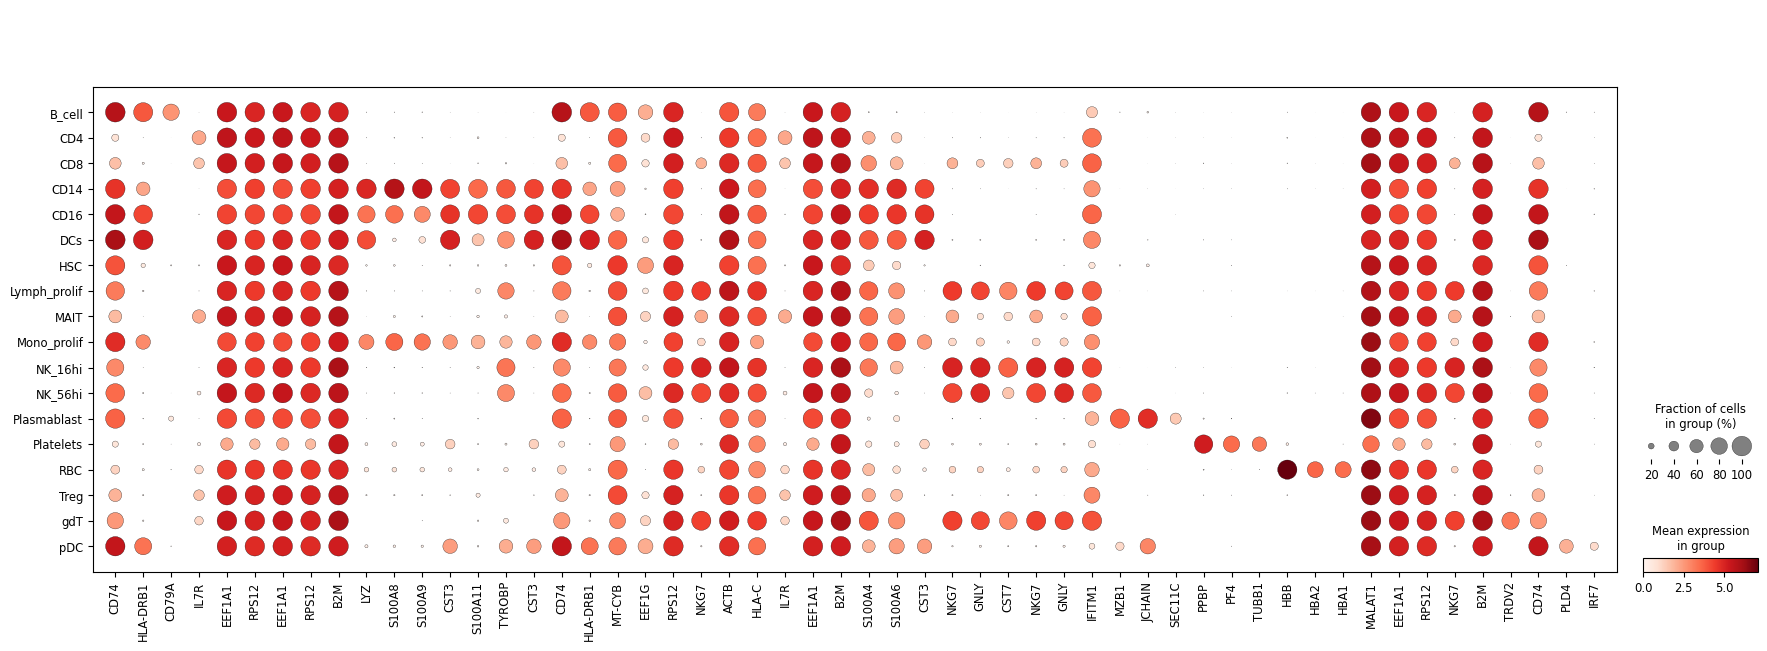

Expression fraction (size) similarity between real and semi-profiled:
PearsonRResult(statistic=0.9813448650480566, pvalue=0.0)
Expression intensity (color) similarity between real and semi-profiled
PearsonRResult(statistic=0.9856091481390721, pvalue=0.0)


In [29]:
print(celltype_signature_comparison.__doc__)
celltype_signature_comparison(gtdata=gtdata,semisdata=semisdata,celltype_key='celltypes')



### Use RRHO plot to compare markers


In [30]:
# choose any cell type
print(totaltypes)
selected_celltype = 'CD4'

['B_cell' 'CD4' 'CD8' 'CD14' 'CD16' 'DCs' 'HSC' 'Lymph_prolif' 'MAIT'
 'Mono_prolif' 'NK_16hi' 'NK_56hi' 'Plasmablast' 'Platelets' 'RBC' 'Treg'
 'gdT' 'pDC']



    Use RRHO graph to compare the positive and negative markers found using real-profiled and semi-profiled datasets.
    
    Parameters
    ----------
    gtdata:
        Real-profiled (ground truth) data
    semisdata:
        Semi-profiled dataset
    celltype_key:
        The key in anndata.AnnData.obs for storing the cell type information
    celltype:
        The selected cell type to analyze 

    Returns
    -------
        None

    Example
    -------
    >>> rrho(gtdata=gtdata,semisdata=semisdata,celltype_key='celltypes',celltype='CD4')
    
Plotting RRHO for comparing CD4 markers.


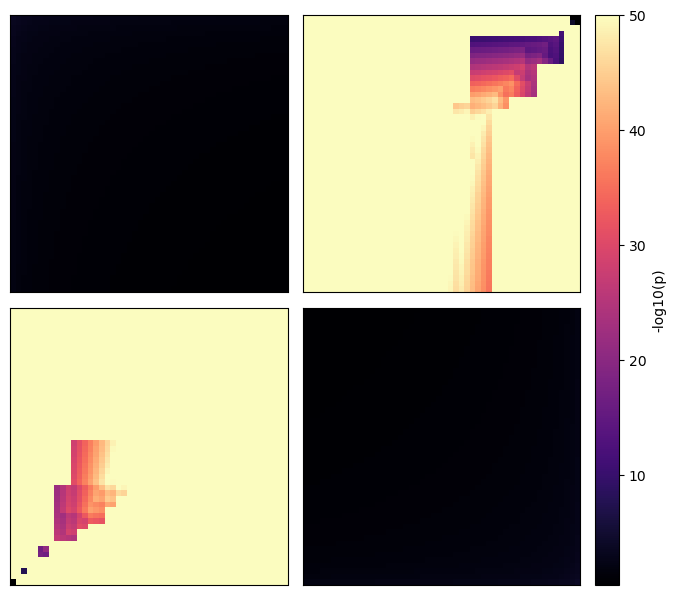

In [31]:
print(rrho.__doc__)
rrho(gtdata=gtdata,semisdata=semisdata,celltype_key='celltypes',celltype=selected_celltype)


### Compare GO enrichment analysis similarity


    Compare the enrichment analysis results using the real-profiled and semi-profiled datasets. 
    
    Parameters
    ----------
    name:
        Project name
    gtdata:
        Real-profiled (ground truth) data
    semisdata:
        Semi-profiled dataset
    celltype_key:
        The key in anndata.AnnData.obs for storing the cell type information
    selectedtype:
        The selected cell type to analyze 

    Returns
    -------
        None

    Example
    -------
    >>> enrichment_comparison(name, gtdata, semisdata, celltype_key = 'celltypes', selectedtype = 'CD4')

    
p-value of hypergeometric test for overlapping DEGs: 8.123156530740906e-169
Significance correlation: PearsonRResult(statistic=0.99828149443486, pvalue=3.705081963261479e-16)


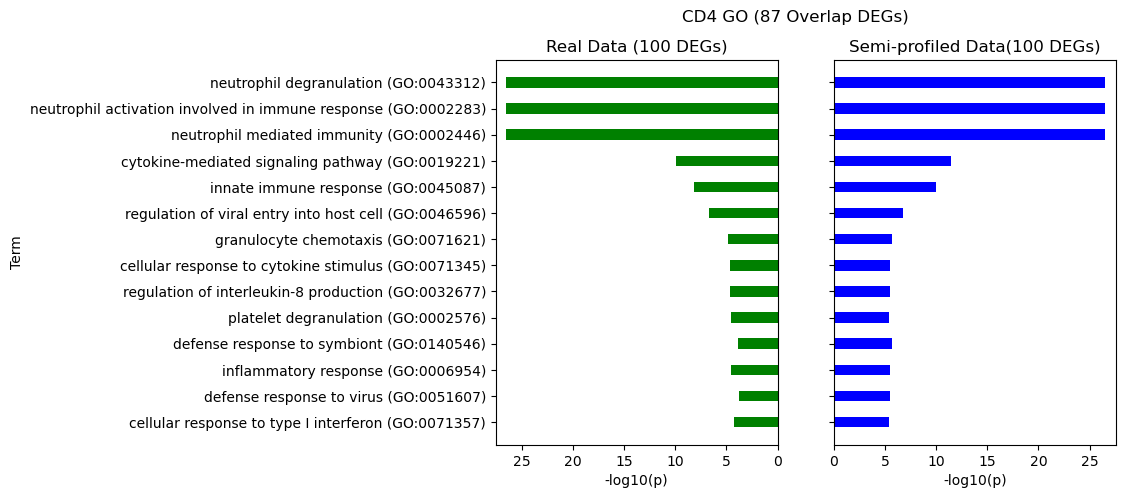

In [32]:
selected_celltype = 'CD4'
print(enrichment_comparison.__doc__)
enrichment_comparison(name, gtdata, semisdata, celltype_key = 'celltypes', selectedtype = selected_celltype)



### Compare partition-based graph abstraction (PAGA) graph similarity

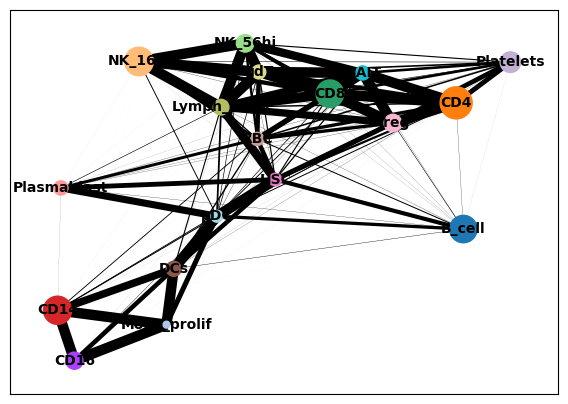

In [33]:
# GROUND TRUTH
threshold = 0
sc.tl.pca(gtdata,n_comps=100)
sc.pp.neighbors(gtdata,use_rep='X_pca',n_neighbors=50)
sc.tl.paga(gtdata, groups = 'celltypes')
sc.pl.paga(gtdata, plot=True,threshold=threshold)

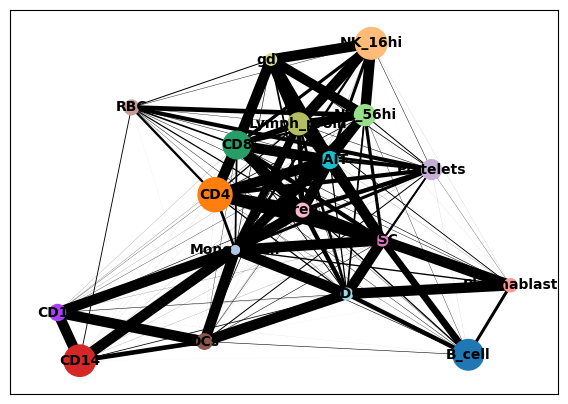

In [34]:
# SEMI-PROFILED
threshold = 0
sc.tl.pca(semisdata,n_comps=100)
sc.pp.neighbors(semisdata,use_rep='X_pca',n_neighbors=50)
sc.tl.paga(semisdata, groups = 'celltypes')
sc.pl.paga(semisdata, plot=True,threshold=threshold)

In [35]:
gtpaga = np.array(gtdata.uns['paga']['connectivities'].todense())
semipaga = np.array(semisdata.uns['paga']['connectivities'].todense())
gtpaga = gtpaga.reshape((-1))
semipaga= semipaga.reshape((-1))
print('Correlation between the two adjacency matrices:')
scipy.stats.pearsonr(gtpaga,semipaga)

Correlation between the two adjacency matrices:


PearsonRResult(statistic=0.8000461899090042, pvalue=1.9685934338121724e-73)

### Using CellChat to perform cell-cell interaction analysis
If you would like to perform cell-cell interaction analysis using CellChat, we recommend creating another conda environment according to the instructions below: \
Create environment: 
```
conda create -n r_analysis r-essentials r-base
```
Activate it: 
```
conda activate r_analysis
```
Start an interactive R session:
```
R
```
Install necessary packages:

1
```
install.packages('devtools')
```

2
```
if (!require("BiocManager", quietly = TRUE))
    install.packages("BiocManager")
 
BiocManager::install("Biobase")
```

3 
```
if (!require("BiocManager", quietly = TRUE))
    install.packages("BiocManager")
 
BiocManager::install("ComplexHeatmap")
```

4
```
if (!require("BiocManager", quietly = TRUE))
    install.packages("BiocManager")
 
BiocManager::install("BiocNeighbors")
```

5
```
devtools::install_github("sqjin/CellChat")
```

Then install this R environment as a Jupyter Notebook kernel:

```
install.packages('IRkernel')
IRkernel::installspec(user = TRUE)

```

This finishes configuring the environment needed. You should be able to select the 'R' kernel in Jupyter Notebook. We will export some single-cell data for cell-cell interaction analysis.

### Export single-cell data for analysis
We export real and semi-profiled cells from moderate COVID-19 patients.

In [36]:
condition_real = gtdata[gtdata.obs['states_collection_sum'] == 'Moderate']
condition_semi = semisdata[semidata.obs['states_collection_sum'] == 'Moderate']
condition_real.write(name + '/moderate_real.h5ad')
condition_semi.write(name + '/moderate_semi.h5ad')

Then please open our notebook "cellchat_eg.ipynb" to proceed with the analysis. 

## End of comprehensive semi-profiling performance evaluation
Based on only two representative samples, the semi-profiled 12-sample cohort has very similar downstream analysis results as the real-profiled cohort, which contains heterogeneous samples from 6 different COVID-19 severity levels.

## Optional: New Representative Selection and Run the Next Round
You have the option to employ active learning for the selection of additional representatives. This approach can result in some target samples having more similar representatives, thereby enhancing the accuracy of the inference process.

## Round 2 semi-profiling

### select a new batch of representatives using active learning:

In [43]:
representatives = name + '/status/init_representatives.txt'
cluster = name + '/status/init_cluster_labels.txt'
targetid = None
bulktype = 'pseudobulk'

In [45]:
print(semi.activeselection.__doc__)


    Use active learning to select the next batch of representatives
    
    Parameters
    ----------
    name 
        Project name.
    representatives
        Path to a `.txt` file specifying the representatives.
    cluster
        Path to a `.txt` file specifying the cluster labels.
    batch
        Representative selection batch size.
    lambdasc
        Scaling factor for the single-cell transformation difficulty from the representative to the target.
    lambdapb
        Scaling factor for the pseudobulk data.difference. 
    
    Returns
    -------
        None
    
    Example
    -------
    >>> name = 'project_name'
    >>> representatives = name + '/status/init_representatives.txt'
    >>> cluster = name + '/status/init_cluster_labels.txt'
    >>> semidev.activeselection(name, representatives,cluster,batch=2,lambdasc=1,lambdapb=1)
    
    


In [44]:
semi.activeselection(name, representatives,cluster,batch=2,lambdasc=1,lambdapb=1)



Running active learning to select new representatives
selection finished


"\nscSemiProfiler.activeselection.activeselection(name, representatives,\n cluster, batch, lambdasc, lambdapb)\n\nParameters:\n- name ('str'): Project name.\n- representatives ('str'): A `.txt` file specifying the representatives.\n- cluster ('str'): A `.txt` file specifying the cluster labels.\n- batch: ('int'): Representative selection batch size.\n- lambdasc ('float'): Scaling factor for the single-cell transformation difficulty from the representative to the target.\n- lambdapb ('float'): Scaling factor for the pseudobulk data.difference. \n\nReturns:\n- None\n"

### obtain single-cell data for new representatives:

In [48]:
get_eg_representatives(name)

Obtained single-cell data for representatives.


In [50]:
semi.scprocess(name=name,singlecell=name+'/representative_sc.h5ad',normed='yes',cellfilter='no',threshold=1e-3,geneset='yes',weight='yes',k=15)

Processing representative single-cell data
Removing background noise
Computing geneset scores
GMT file c2.cp.v7.4.symbols.gmt loading ... 
2922
Number of genes in c2.cp.v7.4.symbols.gmt 4240
GMT file c2.cp.v7.4.symbols.gmt loading ... 
2922
Number of genes in c2.cp.v7.4.symbols.gmt 4240
GMT file c2.cp.v7.4.symbols.gmt loading ... 
2922
Number of genes in c2.cp.v7.4.symbols.gmt 4240
GMT file c2.cp.v7.4.symbols.gmt loading ... 
2922
Number of genes in c2.cp.v7.4.symbols.gmt 4240
Augmenting and saving single-cell data.
Finished processing representative single-cell data


### run single-cell inference again with more representatives:

In [51]:
representatives = name + '/status/eer_representatives_2.txt'
cluster = name + '/status/eer_cluster_labels_2.txt'
bulktype = 'pseudobulk'

semi.scinfer(name, representatives, cluster, None, bulktype)

Start single-cell inference in cohort mode
pretrain 1: representative reconstruction
load existing pretrain 1 reconstruction model for BGCV09_CV0279
INFO     Generating sequential column names                                                                        
load existing pretrain 1 reconstruction model for MH9143426
INFO     Generating sequential column names                                                                        
INFO     Generating sequential column names                                                                        


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA A16') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 100/100: 100%|█| 100/100 [00:29<00:00,  3.37it/s, v_num=1, train_loss_step=66

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 100/100: 100%|█| 100/100 [00:29<00:00,  3.37it/s, v_num=1, train_loss_step=66

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA A16') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]



Epoch 300/300: 100%|█| 300/300 [03:42<00:00,  1.04it/s, v_num=1, train_loss_step=60

`Trainer.fit` stopped: `max_epochs=300` reached.


Epoch 300/300: 100%|█| 300/300 [03:42<00:00,  1.35it/s, v_num=1, train_loss_step=60
INFO     Generating sequential column names                                                                        


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA A16') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 100/100: 100%|█| 100/100 [00:22<00:00,  4.37it/s, v_num=1, train_loss_step=96

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 100/100: 100%|█| 100/100 [00:22<00:00,  4.36it/s, v_num=1, train_loss_step=96

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA A16') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]



Epoch 300/300: 100%|█| 300/300 [02:49<00:00,  1.30it/s, v_num=1, train_loss_step=70

`Trainer.fit` stopped: `max_epochs=300` reached.


Epoch 300/300: 100%|█| 300/300 [02:49<00:00,  1.77it/s, v_num=1, train_loss_step=70
pretrain2: reconstruction with representative bulk loss
load existing model
load existing pretrain 2 model for BGCV09_CV0279
INFO     Generating sequential column names                                                                        
load existing model
load existing pretrain 2 model for MH9143426
INFO     Generating sequential column names                                                                        
load existing model
INFO     Generating sequential column names                                                                        
INFO     Generating sequential column names                                                                        


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA A16') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 50/50: 100%|█| 50/50 [00:15<00:00,  3.18it/s, v_num=1, train_loss_step=492, t

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 50/50: 100%|█| 50/50 [00:15<00:00,  3.18it/s, v_num=1, train_loss_step=492, t

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA A16') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]



Epoch 150/150: 100%|█| 150/150 [01:52<00:00,  1.01it/s, v_num=1, train_loss_step=51

`Trainer.fit` stopped: `max_epochs=150` reached.


Epoch 150/150: 100%|█| 150/150 [01:52<00:00,  1.33it/s, v_num=1, train_loss_step=51
load existing model
INFO     Generating sequential column names                                                                        
INFO     Generating sequential column names                                                                        


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA A16') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 50/50: 100%|█| 50/50 [00:12<00:00,  4.02it/s, v_num=1, train_loss_step=630, t

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 50/50: 100%|█| 50/50 [00:12<00:00,  4.13it/s, v_num=1, train_loss_step=630, t

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA A16') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]



Epoch 150/150: 100%|█| 150/150 [01:26<00:00,  1.32it/s, v_num=1, train_loss_step=67

`Trainer.fit` stopped: `max_epochs=150` reached.


Epoch 150/150: 100%|█| 150/150 [01:26<00:00,  1.73it/s, v_num=1, train_loss_step=67
inference
Inference for AP8 has been finished previously. Skip.
Inference for BGCV02_CV0068 has been finished previously. Skip.
Inference for BGCV03_CV0084 has been finished previously. Skip.
Inference for BGCV03_CV0176 has been finished previously. Skip.
Inference for BGCV04_CV0164 has been finished previously. Skip.
INFO     Generating sequential column names                                                                        
INFO     Generating sequential column names                                                                        


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA A16') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 150/150: 100%|█| 150/150 [00:20<00:00,  7.12it/s, v_num=1, train_loss_step=67

`Trainer.fit` stopped: `max_epochs=150` reached.


Epoch 150/150: 100%|█| 150/150 [00:20<00:00,  7.45it/s, v_num=1, train_loss_step=67


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA A16') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 150/150: 100%|█| 150/150 [00:20<00:00,  6.93it/s, v_num=1, train_loss_step=68

`Trainer.fit` stopped: `max_epochs=150` reached.


Epoch 150/150: 100%|█| 150/150 [00:20<00:00,  7.35it/s, v_num=1, train_loss_step=68


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA A16') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 150/150: 100%|█| 150/150 [00:20<00:00,  7.08it/s, v_num=1, train_loss_step=68

`Trainer.fit` stopped: `max_epochs=150` reached.


Epoch 150/150: 100%|█| 150/150 [00:20<00:00,  7.49it/s, v_num=1, train_loss_step=68


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA A16') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 150/150: 100%|█| 150/150 [00:20<00:00,  6.85it/s, v_num=1, train_loss_step=68

`Trainer.fit` stopped: `max_epochs=150` reached.


Epoch 150/150: 100%|█| 150/150 [00:20<00:00,  7.35it/s, v_num=1, train_loss_step=68


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA A16') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 150/150: 100%|█| 150/150 [00:20<00:00,  7.15it/s, v_num=1, train_loss_step=68

`Trainer.fit` stopped: `max_epochs=150` reached.


Epoch 150/150: 100%|█| 150/150 [00:20<00:00,  7.44it/s, v_num=1, train_loss_step=68
Inference for MH9143322 has been finished previously. Skip.
Inference for newcastle20 has been finished previously. Skip.
Finished single-cell inference


## stop criteria
In real world application, you do not have the ground truth data for evaluating semi-profiling performance. But you can decide if you want to stop or continue semi-profiling with more representatives based on your budget, or evaluating the semi-profiling performance by comparing the representatives and their inferred data in the previous round.

In [52]:
## GET REAL AND INFERRED NEW REPRESENTATIVES:

print(assemble_representatives.__doc__)
real_rep, inferred_rep = assemble_representatives(name,celltype_key='celltypes',sample_info_keys = ['states_collection_sum'],rnd=2,batch=2)




    Assemble previous round of inferred representative data and annotate the cell type. The real-profiled representatives in the current round is also provided for comparison.
    
    Parameters
    ----------
    name: 
        Project name
    celltype_key:
        The key in .obs specifying the cell type information
    sample_info_keys:
        Keys for other sample-level information to be stored in the assembled dataset
    rnd:
        The round of semi-profiling to assemble. For example, select the second round (2 batches of representatives) using rnd = 2
    batch:
        The representative selection batch size

    Returns
    -------
    realrepdata:
        The real-profiled representative dataset
    infrepdata:
        The inferred representative dataset

    Example
    -------
    >>> real_rep, inferred_rep = assemble_representatives(name,celltype_key='celltypes',sample_info_keys = ['states_collection_sum'],rnd=2,batch=2)


    
Training cell type annotator.
Finished.

then you can compare them using any of the anlaysis tasks shown previously, e.g UMAP, deconvolution.


    Compare the real-profiled and semi-profiled datasets by plotting them in a same UMAP
    
    Parameters
    ----------
    semidata:
        Semi-profiled dataset
    gtdata:
        Real-profiled dataset
    name: 
        Project name
    celltype_key:
        The key in .obs specifying the cell type information

    Returns
    -------
    combdata
        Combined dataset, with real-profiled cells in the front
    gtdata
        Real-profiled dataset
    semidata
        Semi-profiled dataset
        
    Example
    -------
    >>> combdata, gtdata, semidata = compare_adata_umaps(
    >>> inferred_rep, # inferred representatives from the last round
    >>> real_rep,     # real-profiled representatives from the current round          
    >>> name = name,  # project name
    >>> celltype_key = 'celltypes'
    >>> )
        
    


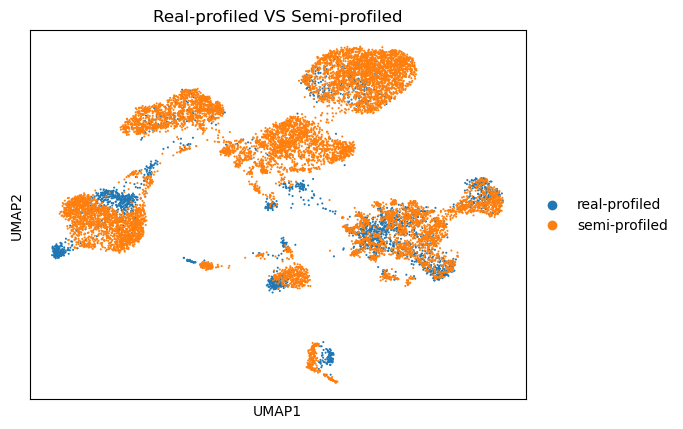

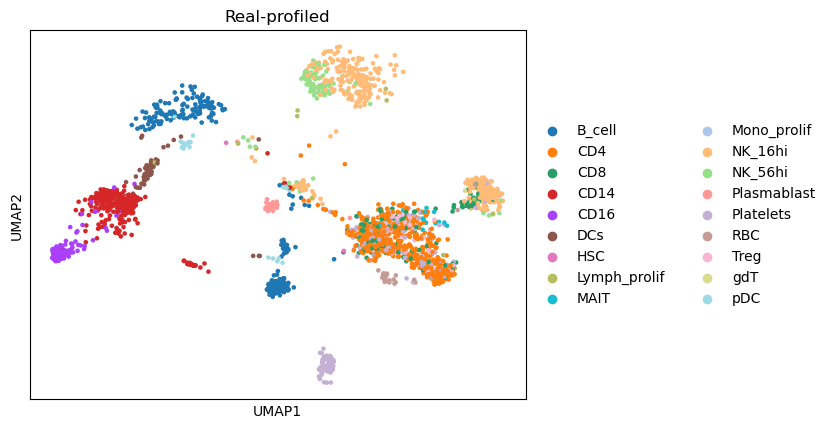

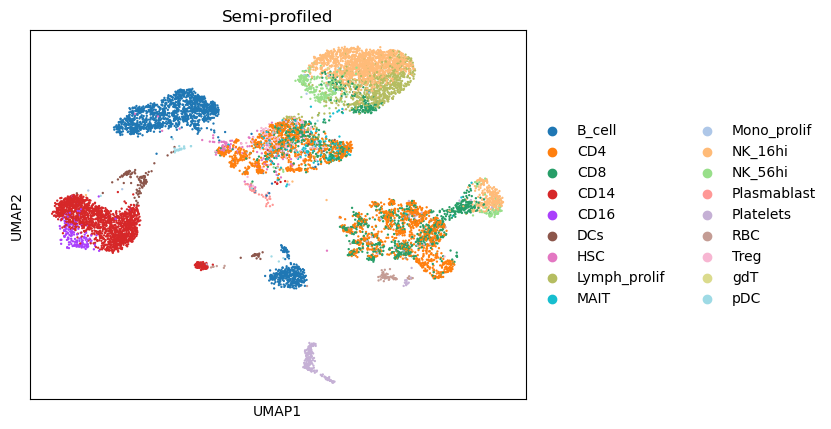

In [53]:
print(compare_adata_umaps.__doc__)
_ = compare_adata_umaps(
    inferred_rep,
    real_rep,                
    name = name,
    celltype_key = 'celltypes'
    )


In [54]:
totaltypes = np.array(inferred_rep.obs['celltypes'].cat.categories)
real_prop = celltype_proportion(real_rep,totaltypes)
inferred_prop = celltype_proportion(inferred_rep,totaltypes)
print('Pearson Correlation between the two versions of cell type proportions:')
print(scipy.stats.pearsonr(real_prop,inferred_prop))

Pearson Correlation between the two versions of cell type proportions:
PearsonRResult(statistic=0.8861173259711917, pvalue=9.895243945706982e-07)


A Pearson Correlation of 0.886 is generally considered as good deconvolution performance. So if your are mainly focusing on cell type-level analysis then you can stop here. If you are not satisfied with it or not satisfied with more in-depth analysis results, you can select more representatives and go to the next round.

## new representative selection using active learning

In [56]:
semi.activeselection(name, representatives,cluster,batch=2,lambdasc=1,lambdapb=1)

Running active learning to select new representatives
selection finished


## Round 3 semi-profiling

In [61]:
get_eg_representatives(name)
semi.scprocess(name=name,singlecell=name+'/representative_sc.h5ad',normed='yes',cellfilter='no',threshold=1e-3,geneset='yes',weight='yes',k=15)

Obtained single-cell data for representatives.
Processing representative single-cell data
Removing background noise
Computing geneset scores
GMT file c2.cp.v7.4.symbols.gmt loading ... 
2922
Number of genes in c2.cp.v7.4.symbols.gmt 4240
GMT file c2.cp.v7.4.symbols.gmt loading ... 
2922
Number of genes in c2.cp.v7.4.symbols.gmt 4240
GMT file c2.cp.v7.4.symbols.gmt loading ... 
2922
Number of genes in c2.cp.v7.4.symbols.gmt 4240
GMT file c2.cp.v7.4.symbols.gmt loading ... 
2922
Number of genes in c2.cp.v7.4.symbols.gmt 4240
GMT file c2.cp.v7.4.symbols.gmt loading ... 
2922
Number of genes in c2.cp.v7.4.symbols.gmt 4240
GMT file c2.cp.v7.4.symbols.gmt loading ... 
2922
Number of genes in c2.cp.v7.4.symbols.gmt 4240
Augmenting and saving single-cell data.
Finished processing representative single-cell data


In [62]:
representatives = name + '/status/eer_representatives_3.txt'
cluster = name + '/status/eer_cluster_labels_3.txt'
semi.scinfer(name, representatives,cluster,None,bulktype,device = 'cuda:0')

Start single-cell inference in cohort mode
pretrain 1: representative reconstruction
load existing pretrain 1 reconstruction model for BGCV09_CV0279
INFO     Generating sequential column names                                                                        
load existing pretrain 1 reconstruction model for MH9143426
INFO     Generating sequential column names                                                                        
load existing pretrain 1 reconstruction model for BGCV07_CV0137
INFO     Generating sequential column names                                                                        
load existing pretrain 1 reconstruction model for MH8919226
INFO     Generating sequential column names                                                                        
INFO     Generating sequential column names                                                                        


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA A16') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 100/100: 100%|█| 100/100 [00:28<00:00,  3.60it/s, v_num=1, train_loss_step=58

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 100/100: 100%|█| 100/100 [00:28<00:00,  3.57it/s, v_num=1, train_loss_step=58

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA A16') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]



Epoch 300/300: 100%|█| 300/300 [03:21<00:00,  1.11it/s, v_num=1, train_loss_step=50

`Trainer.fit` stopped: `max_epochs=300` reached.


Epoch 300/300: 100%|█| 300/300 [03:21<00:00,  1.49it/s, v_num=1, train_loss_step=50
INFO     Generating sequential column names                                                                        


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA A16') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 100/100: 100%|█| 100/100 [01:41<00:00,  1.01s/it, v_num=1, train_loss_step=53

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 100/100: 100%|█| 100/100 [01:41<00:00,  1.01s/it, v_num=1, train_loss_step=53

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA A16') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]



Epoch 300/300: 100%|█| 300/300 [11:54<00:00,  3.23s/it, v_num=1, train_loss_step=55

`Trainer.fit` stopped: `max_epochs=300` reached.


Epoch 300/300: 100%|█| 300/300 [11:54<00:00,  2.38s/it, v_num=1, train_loss_step=55
pretrain2: reconstruction with representative bulk loss
load existing model
load existing pretrain 2 model for BGCV09_CV0279
INFO     Generating sequential column names                                                                        
load existing model
load existing pretrain 2 model for MH9143426
INFO     Generating sequential column names                                                                        
load existing model
load existing pretrain 2 model for BGCV07_CV0137
INFO     Generating sequential column names                                                                        
load existing model
load existing pretrain 2 model for MH8919226
INFO     Generating sequential column names                                                                        
load existing model
INFO     Generating sequential column names                                                                 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA A16') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 50/50: 100%|█| 50/50 [00:14<00:00,  3.37it/s, v_num=1, train_loss_step=497, t

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 50/50: 100%|█| 50/50 [00:14<00:00,  3.37it/s, v_num=1, train_loss_step=497, t

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA A16') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]



Epoch 150/150: 100%|█| 150/150 [01:39<00:00,  1.10it/s, v_num=1, train_loss_step=47

`Trainer.fit` stopped: `max_epochs=150` reached.


Epoch 150/150: 100%|█| 150/150 [01:39<00:00,  1.51it/s, v_num=1, train_loss_step=47
load existing model
INFO     Generating sequential column names                                                                        
INFO     Generating sequential column names                                                                        


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA A16') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 50/50: 100%|█| 50/50 [00:48<00:00,  1.07s/it, v_num=1, train_loss_step=519, t

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 50/50: 100%|█| 50/50 [00:48<00:00,  1.04it/s, v_num=1, train_loss_step=519, t

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA A16') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]



Epoch 150/150: 100%|█| 150/150 [06:03<00:00,  3.37s/it, v_num=1, train_loss_step=50

`Trainer.fit` stopped: `max_epochs=150` reached.


Epoch 150/150: 100%|█| 150/150 [06:03<00:00,  2.42s/it, v_num=1, train_loss_step=50
inference
Inference for BGCV02_CV0068 has been finished previously. Skip.
Inference for BGCV03_CV0176 has been finished previously. Skip.
Inference for BGCV04_CV0164 has been finished previously. Skip.
Inference for MH8919227 has been finished previously. Skip.
Inference for MH9143322 has been finished previously. Skip.
Inference for newcastle20 has been finished previously. Skip.
Finished single-cell inference


In [63]:
semi.activeselection(name, representatives,cluster,batch=2,lambdasc=1,lambdapb=1)

Running active learning to select new representatives
selection finished


## Round 4 semi-profiling

In [67]:
get_eg_representatives(name)
semi.scprocess(name=name,singlecell=name+'/representative_sc.h5ad',normed='yes',cellfilter='no',threshold=1e-3,geneset='yes',weight='yes',k=15)
representatives = name + '/status/eer_representatives_4.txt'
cluster = name + '/status/eer_cluster_labels_4.txt'
semi.scinfer(name, representatives,cluster,None,bulktype,device = 'cuda:0')

Obtained single-cell data for representatives.
Processing representative single-cell data
Removing background noise
Computing geneset scores
GMT file c2.cp.v7.4.symbols.gmt loading ... 
2922
Number of genes in c2.cp.v7.4.symbols.gmt 4240
GMT file c2.cp.v7.4.symbols.gmt loading ... 
2922
Number of genes in c2.cp.v7.4.symbols.gmt 4240
GMT file c2.cp.v7.4.symbols.gmt loading ... 
2922
Number of genes in c2.cp.v7.4.symbols.gmt 4240
GMT file c2.cp.v7.4.symbols.gmt loading ... 
2922
Number of genes in c2.cp.v7.4.symbols.gmt 4240
GMT file c2.cp.v7.4.symbols.gmt loading ... 
2922
Number of genes in c2.cp.v7.4.symbols.gmt 4240
GMT file c2.cp.v7.4.symbols.gmt loading ... 
2922
Number of genes in c2.cp.v7.4.symbols.gmt 4240
GMT file c2.cp.v7.4.symbols.gmt loading ... 
2922
Number of genes in c2.cp.v7.4.symbols.gmt 4240
GMT file c2.cp.v7.4.symbols.gmt loading ... 
2922
Number of genes in c2.cp.v7.4.symbols.gmt 4240
GMT file c2.cp.v7.4.symbols.gmt loading ... 
2922
Number of genes in c2.cp.v7.4.sym

In [68]:
semi.activeselection(name, representatives,cluster,batch=2,lambdasc=1,lambdapb=1)

Running active learning to select new representatives
selection finished


## Round 5 semi-profiling

In [70]:
get_eg_representatives(name)
semi.scprocess(name=name,singlecell=name+'/representative_sc.h5ad',normed='yes',cellfilter='no',threshold=1e-3,geneset='yes',weight='yes',k=15)
representatives = name + '/status/eer_representatives_5.txt'
cluster = name + '/status/eer_cluster_labels_5.txt'
semi.scinfer(name, representatives,cluster,None,bulktype,device = 'cuda:0')
semi.activeselection(name, representatives,cluster,batch=2,lambdasc=1,lambdapb=1)

Obtained single-cell data for representatives.
Processing representative single-cell data
Removing background noise
Computing geneset scores
GMT file c2.cp.v7.4.symbols.gmt loading ... 
2922
Number of genes in c2.cp.v7.4.symbols.gmt 4240
GMT file c2.cp.v7.4.symbols.gmt loading ... 
2922
Number of genes in c2.cp.v7.4.symbols.gmt 4240
GMT file c2.cp.v7.4.symbols.gmt loading ... 
2922
Number of genes in c2.cp.v7.4.symbols.gmt 4240
GMT file c2.cp.v7.4.symbols.gmt loading ... 
2922
Number of genes in c2.cp.v7.4.symbols.gmt 4240
GMT file c2.cp.v7.4.symbols.gmt loading ... 
2922
Number of genes in c2.cp.v7.4.symbols.gmt 4240
GMT file c2.cp.v7.4.symbols.gmt loading ... 
2922
Number of genes in c2.cp.v7.4.symbols.gmt 4240
GMT file c2.cp.v7.4.symbols.gmt loading ... 
2922
Number of genes in c2.cp.v7.4.symbols.gmt 4240
GMT file c2.cp.v7.4.symbols.gmt loading ... 
2922
Number of genes in c2.cp.v7.4.symbols.gmt 4240
GMT file c2.cp.v7.4.symbols.gmt loading ... 
2922
Number of genes in c2.cp.v7.4.sym

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA A16') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 100/100: 100%|█| 100/100 [00:52<00:00,  1.91it/s, v_num=1, train_loss_step=51

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 100/100: 100%|█| 100/100 [00:52<00:00,  1.91it/s, v_num=1, train_loss_step=51

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA A16') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]



Epoch 300/300: 100%|█| 300/300 [06:28<00:00,  1.62s/it, v_num=1, train_loss_step=49

`Trainer.fit` stopped: `max_epochs=300` reached.


Epoch 300/300: 100%|█| 300/300 [06:28<00:00,  1.30s/it, v_num=1, train_loss_step=49
INFO     Generating sequential column names                                                                        


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA A16') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 100/100: 100%|█| 100/100 [00:40<00:00,  2.48it/s, v_num=1, train_loss_step=74

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 100/100: 100%|█| 100/100 [00:40<00:00,  2.48it/s, v_num=1, train_loss_step=74

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA A16') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]



Epoch 300/300: 100%|█| 300/300 [05:01<00:00,  1.31s/it, v_num=1, train_loss_step=67

`Trainer.fit` stopped: `max_epochs=300` reached.


Epoch 300/300: 100%|█| 300/300 [05:01<00:00,  1.00s/it, v_num=1, train_loss_step=67
pretrain2: reconstruction with representative bulk loss
load existing model
load existing pretrain 2 model for BGCV09_CV0279
INFO     Generating sequential column names                                                                        
load existing model
load existing pretrain 2 model for MH9143426
INFO     Generating sequential column names                                                                        
load existing model
load existing pretrain 2 model for BGCV07_CV0137
INFO     Generating sequential column names                                                                        
load existing model
load existing pretrain 2 model for MH8919226
INFO     Generating sequential column names                                                                        
load existing model
load existing pretrain 2 model for BGCV03_CV0084
INFO     Generating sequential column names                

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA A16') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 50/50: 100%|█| 50/50 [00:27<00:00,  1.80it/s, v_num=1, train_loss_step=537, t

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 50/50: 100%|█| 50/50 [00:27<00:00,  1.80it/s, v_num=1, train_loss_step=537, t

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA A16') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]



Epoch 150/150: 100%|█| 150/150 [03:15<00:00,  1.67s/it, v_num=1, train_loss_step=41

`Trainer.fit` stopped: `max_epochs=150` reached.


Epoch 150/150: 100%|█| 150/150 [03:15<00:00,  1.31s/it, v_num=1, train_loss_step=41
load existing model
INFO     Generating sequential column names                                                                        
INFO     Generating sequential column names                                                                        


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA A16') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 50/50: 100%|█| 50/50 [00:21<00:00,  2.33it/s, v_num=1, train_loss_step=653, t

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 50/50: 100%|█| 50/50 [00:21<00:00,  2.34it/s, v_num=1, train_loss_step=653, t

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA A16') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]



Epoch 150/150: 100%|█| 150/150 [02:32<00:00,  1.31s/it, v_num=1, train_loss_step=66

`Trainer.fit` stopped: `max_epochs=150` reached.


Epoch 150/150: 100%|█| 150/150 [02:32<00:00,  1.02s/it, v_num=1, train_loss_step=66
inference
Inference for BGCV03_CV0176 has been finished previously. Skip.
Inference for MH9143322 has been finished previously. Skip.
Finished single-cell inference
Running active learning to select new representatives
selection finished


## Error curve
After performing several rounds of semi-profiling, we can visualize how error and cost changes according to number of representatives selected.


### compute errors of each round

In [71]:
print(get_error.__doc__)
upperbounds, lowerbounds, semierrors, naiveerrors = get_error(name)



    Conclude the semi-profiling history of a project and output the erros, upperbounds, and lower bounds, which are necessary for overall performance evaluation.

    Parameters
    ----------
    name:
        Project name

    Returns
    -------
    upperbounds
        The error upper bounds calculated in each round
    lowerbounds
        The error lower bounds calculated in each round
    semierrors
        The errors of semi-profiling
    naiveerrors
        The errors of the selection-only method 

    Example
    -------
    >>> upperbounds, lowerbounds, semierrors, naiveerrors = get_error(name)

    
loading and processing ground truth data.
finished processing ground truth 1.2593571110628545  seconds
computing error for each round
round  1
loading semi-profiled cohort
1.215162865119055 for loading semi-profiled cohort.
pca
30.587980503914878 for pca
computing errors
116.02898007212207 for computing error.
round  2
loading semi-profiled cohort
0.8021362668368965 for loading s

### visualize the errors


    Visualize the error and cost as more representatives are sequenced.

    Parameters
    ----------
    upperbounds
        The error upper bounds calculated in each round
    lowerbounds
        The error lower bounds calculated in each round
    semierrors
        The errors of semi-profiling
    naiveerrors
        The errors of the selection-only method 
    batch
        Representative selection batch size
    total_samples
        The total number of samples in the cohort

    Returns
    -------
        None

    Example
    -------
    >>> errorcurve(upperbounds, lowerbounds, semierrors, naiveerrors, batch=2,total_samples = 12)

    


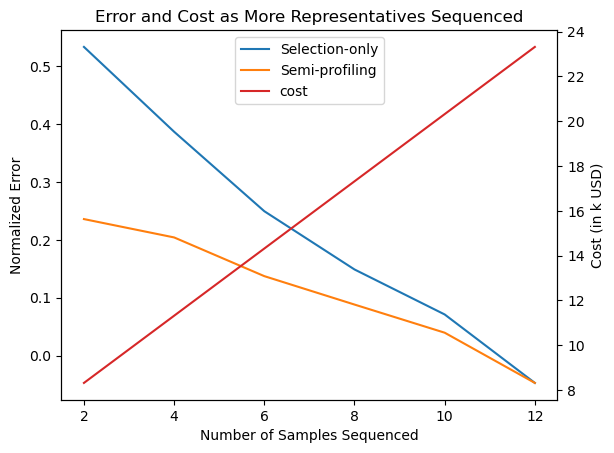

In [72]:
print(errorcurve.__doc__)
errorcurve(upperbounds, lowerbounds, semierrors, naiveerrors, batch=2,total_samples = 12)

